# Phase One: Process AIDA CoNLL-YAGO for Congruence

This notebook takes our input test dataset, AIDA CoNLL-YAGO, and processes it into a form usable for congruence. Notably, this includes a sentence ID and Doc ID for each full_mention that allows us to understand what full_mentions occur in the same context window as well as a list of contextual mentions for every full mention row.

### Import Packages

In [1]:
import os
import time
import csv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

## Load Aida-Conll-Yago

In [2]:
# Relative path to ACY dataset
acy_path = "../../data/aida-conll-yago-dataset/"

# Open raw TSV datafile
acy_file = open(os.path.join(acy_path, "AIDA-YAGO2-DATASET.tsv"))
acy_tsv = csv.reader(acy_file, delimiter="\t")

# Loop through TSV to add to PD.DF
df = []
for row in acy_tsv:
    df.append(row)
acy_df = pd.DataFrame(data=df[1:])
new_columns = ["token", "mention", "full_mention", "YAGO2", "wikipedia_URL", "wikipedia_ID", "freebase"]
acy_df = acy_df.rename(columns=dict(zip(range(7), new_columns)))
acy_df.head(10)

,token,mention,full_mention,YAGO2,wikipedia_URL,wikipedia_ID,freebase
0,EU,B,EU,--NME--,None,None,None
1,rejects,None,None,None,None,None,None
2,German,B,German,Germany,http://en.wikipedia.org/wiki/Germany,11867,/m/0345h
3,call,None,None,None,None,None,None
4,to,None,None,None,None,None,None
5,boycott,None,None,None,None,None,None
6,British,B,British,United_Kingdom,http://en.wikipedia.org/wiki/United_Kingdom,31717,/m/07ssc
7,lamb,None,None,None,None,None,None
8,.,None,None,None,None,None,None
9,None,None,None,None,None,None,None


#### Add Sentence ID

In order to determine which full_mentions occur in the same sentence, we add a Sentence_ID that increases by one whenever it comes across a period and a space (`. None`).


#### Add Doc ID
It appears sample articles are split by a `-DOCSTART-` so we've also added a `doc_id` based on that.

In [3]:
# Confirm length of iteration
print("Tokens in ACY: {:,}".format(len(acy_df)))

Tokens in ACY: 176,615


In [4]:
# Start with sentence_id of 0
sentence_id = 0
doc_id = 0
prior_token = 0

# Prepare list to append
sentence_list = []
doc_list = []

# Iterate through every token to find same sentences
for row in tqdm(range(len(acy_df))):
    
    # Find token and add sentence ID to list
    token = acy_df.iloc[row]['token']
    sentence_list.append(sentence_id)
    
    # If we've reached our sentence stopping condition, increment sentence_id
    if prior_token == "." and token == None:
        sentence_id += 1
    try:
        if "-DOCSTART-" in token:
            doc_id += 1
    except TypeError: # Can't use 'in' when NoneType present
        pass
    doc_list.append(doc_id)
        
    # Update token to prior token
    prior_token = token
        
# Add list to DataFrame as column
acy_df['sentence_id'] = sentence_list
acy_df['doc_id'] = doc_list

100%|██████████| 176615/176615 [00:12<00:00, 14548.17it/s]


In [5]:
# Print out clear example showing increment sentence and doc
acy_df[630:645][['token', 'full_mention', 'sentence_id', 'doc_id']]

,token,full_mention,sentence_id,doc_id
630,a,None,23,1
631,drugs,None,23,1
632,overdose,None,23,1
633,in,None,23,1
634,1970,None,23,1
635,aged,None,23,1
636,27,None,23,1
637,.,None,23,1
638,None,None,23,1
639,-DOCSTART- (3 China),None,24,2


In [6]:
# Create mini copy of dataset
mini_acy_df = acy_df[620:645].copy()

In [7]:
# Test groupby to create contextual mentions on mini version
mini_acy_df.groupby('sentence_id')['full_mention'].agg(['unique'])

,unique
sentence_id,
22,[None]
23,[None]
24,"[None, China, Taiwan]"


In [8]:
%%time
# Run over full dataset
same_sentence_entities = acy_df.groupby('sentence_id')['full_mention'].agg(['unique'])
same_sentence_entities[:5]

CPU times: user 349 ms, sys: 22.9 ms, total: 372 ms
Wall time: 362 ms


,unique
sentence_id,
0,"[EU, None, German, British]"
1,"[Peter Blackburn, None, BRUSSELS, European Com..."
2,"[Germany, None, European Union, Werner Zwingma..."
3,"[None, Commission, Nikolaus van der Pas]"
4,"[None, European Union]"


## Create ACY Dataset where row = full_mention

Now we create a version of the dataset where each row represents a unique instance of a full_mention value - basically all rows where full_mention != None. We do this because we are experimenting with how contextual information provided by nearby full mentions can improve full mention prediction. We leave it to future researchers to investigate how contextual full mentions and contextual non-mention tokens might improve accuracy.

In [9]:
# Drop all tokens that aren't full mentions
acy_input = acy_df[acy_df['full_mention'].notnull()].reset_index(drop=True)
acy_input.head(5)

,token,mention,full_mention,YAGO2,wikipedia_URL,wikipedia_ID,freebase,sentence_id,doc_id
0,EU,B,EU,--NME--,None,None,None,0,0
1,German,B,German,Germany,http://en.wikipedia.org/wiki/Germany,11867,/m/0345h,0,0
2,British,B,British,United_Kingdom,http://en.wikipedia.org/wiki/United_Kingdom,31717,/m/07ssc,0,0
3,Peter,B,Peter Blackburn,--NME--,None,None,None,1,0
4,Blackburn,I,Peter Blackburn,--NME--,None,None,None,1,0


## Process URL into Wikipedia Title

We later use this to match string predictions in certain implementations.

In [10]:
# Define wikipedia_title variable in format with spaces, not underlines
# Values seen as None have type float so checking for that
def replace_lines(text):
    return str(text).replace("_", " ")

# Define wikipedia_title for all values
wikipedia_title = [replace_lines(i.split("/")[-1]) if i is not None else None for i in acy_input['wikipedia_URL']]
display(wikipedia_title[:5])
acy_input['wikipedia_title'] = wikipedia_title
acy_input.head(3)

[None, 'Germany', 'United Kingdom', None, None]

,token,mention,full_mention,YAGO2,wikipedia_URL,wikipedia_ID,freebase,sentence_id,doc_id,wikipedia_title
0,EU,B,EU,--NME--,None,None,None,0,0,None
1,German,B,German,Germany,http://en.wikipedia.org/wiki/Germany,11867,/m/0345h,0,0,Germany
2,British,B,British,United_Kingdom,http://en.wikipedia.org/wiki/United_Kingdom,31717,/m/07ssc,0,0,United Kingdom


## Add Congruent Mentions to Dataframe

In [11]:
# Add congruent mentions to dataframe
congruent_mentions_list = []
for mention in tqdm(range(len(acy_input))):
    sentence_id = acy_input.iloc[mention]['sentence_id']
    congruent_mentions = list(filter(None, same_sentence_entities.iloc[sentence_id][0]))
    congruent_mentions_list.append(congruent_mentions)

acy_input['congruent_mentions'] = congruent_mentions_list

100%|██████████| 29312/29312 [00:05<00:00, 5262.70it/s]


# Final Input Dataset Form

In [12]:
# Drop a few columns we aren't explicitly using
acy_input = acy_input.drop(columns=[
    'token',
    'YAGO2',
    'freebase'
])

In [13]:
# Rename wikipedia_ID to wikipedia_page_ID for clarity
acy_input = acy_input.rename(columns={'wikipedia_ID': 'wikipedia_page_ID'})

In [14]:
# Re-order columns for clarity
column_headers = acy_input.columns.tolist()
print(column_headers)

reordered_columns = column_headers[:4] + [column_headers[-2]] + column_headers[4:6] + [column_headers[-1]]
print(reordered_columns)

assert len(column_headers) == len(reordered_columns)

acy_output = acy_input[reordered_columns]
display(acy_output.head(3))

['mention', 'full_mention', 'wikipedia_URL', 'wikipedia_page_ID', 'sentence_id', 'doc_id', 'wikipedia_title', 'congruent_mentions']
['mention', 'full_mention', 'wikipedia_URL', 'wikipedia_page_ID', 'wikipedia_title', 'sentence_id', 'doc_id', 'congruent_mentions']


,mention,full_mention,wikipedia_URL,wikipedia_page_ID,wikipedia_title,sentence_id,doc_id,congruent_mentions
0,B,EU,None,None,None,0,0,"[EU, German, British]"
1,B,German,http://en.wikipedia.org/wiki/Germany,11867,Germany,0,0,"[EU, German, British]"
2,B,British,http://en.wikipedia.org/wiki/United_Kingdom,31717,United Kingdom,0,0,"[EU, German, British]"


There are a number of full_mentions without a response variable (`wikipedia_URL` or `wikipedia_page_ID`) that we can check accuracy against. We keep these as congruent mentions for improved context later in the pipeline, but we must remember to exclude these when calculating accuracy later as well.

In [15]:
# Size of blank wikipedia_URL problem
print("Percent with No Known True Value: ",\
      round(sum(acy_input['wikipedia_URL'].isnull())/len(acy_output)*100,3), "%")

# Not dropping null true response now but line available if desired
# acy_input = acy_input[acy_input['wikipedia_URL'].notnull()]

Percent with No Known True Value:  24.069 %


### Assess Distribution of Sentence Length

Our input dataset Aida-Conll-Yago defines various types of "sentences", including long listings of sports results as being a part of a single "sentence." We experiment with accuracy and computational performance later in the pipeline using various limits of sentence length, identifying which types of sentences and of which size are most performant. The code below explores the distribution of unique sentence lengths and allows filtering to various lengths.

In [16]:
# What is the maximum number of contextual entities in a single sentence
max(acy_output['congruent_mentions'].apply(len))

194

In [17]:
# How many full mention instances are there in total
len(acy_output['congruent_mentions'])

29312

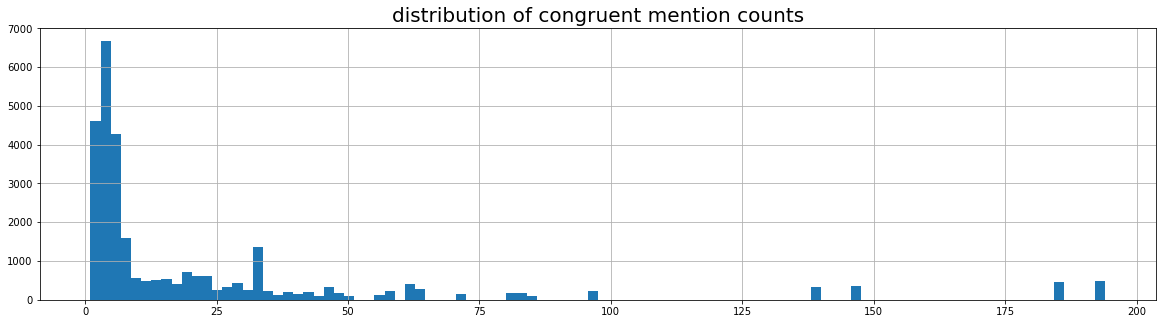

In [18]:
# What is the distribution of contextual mention counts for unique sentences
plt.figure(figsize=(20,5))
acy_output['congruent_mentions'].apply(len).hist(bins=100)
plt.title("distribution of congruent mention counts", size=20)
plt.show()

In [19]:
## Which sentences are of interest

# Experimentation on downstream performance suggests 25 is a sweetpoint where congruence is most impactful for accuracy
# Ideal for max accuracy is 25, smaller necessary for centroid computation is 5

sentence_ids = acy_output[acy_output['congruent_mentions'].apply(len) > 25]['sentence_id'].unique()

In [20]:
# Filter out sentence_ids representing long congruent mentions
# These overly long congruent mentions are usually list of sports results
acy_output = acy_output[~acy_output['sentence_id'].isin(sentence_ids)]
assert sum(acy_output['sentence_id'].isin(sentence_ids)) == 0

### Save Processed Input

In [21]:
print("Length of Final Input Dataset: {:,}".format(len(acy_output)))
acy_output.head(5)

Length of Final Input Dataset: 21,810


,mention,full_mention,wikipedia_URL,wikipedia_page_ID,wikipedia_title,sentence_id,doc_id,congruent_mentions
0,B,EU,None,None,None,0,0,"[EU, German, British]"
1,B,German,http://en.wikipedia.org/wiki/Germany,11867,Germany,0,0,"[EU, German, British]"
2,B,British,http://en.wikipedia.org/wiki/United_Kingdom,31717,United Kingdom,0,0,"[EU, German, British]"
3,B,Peter Blackburn,None,None,None,1,0,"[Peter Blackburn, BRUSSELS, European Commissio..."
4,I,Peter Blackburn,None,None,None,1,0,"[Peter Blackburn, BRUSSELS, European Commissio..."


In [22]:
acy_output.to_csv(os.path.join(acy_path, "Aida-Conll-Yago-Input.csv"), index=False)